# Solver

In [2]:
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../modules'))
import notebook_loading

# from bn_FCN_Train import bn_FCN_Train
from aas_Data import *
# from bn_FC_Network import bn_FC_Network

importing Jupyter notebook from aas_Data.ipynb


In [3]:
# extract the redundant baselines and their gains and data from miriad and calfits files
red_bls, gains, uvd = load_relevant_data('../zen_data/zen.2458098.58037.xx.HH.uv','../zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

# seperate trining and testing redundant baselines 
# if we have not already done this, load them from disk
training_redundant_baselines_dict, testing_redundant_baselines_dict = get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys())

In [4]:
# # seperate the visiblites
training_baselines_data = get_seps_data(training_redundant_baselines_dict, uvd)
testing_baselines_data = get_seps_data(testing_redundant_baselines_dict, uvd)

In [76]:
def get_A_row(two_seps, max_ant_idx):

    # how exactly does this work?
    # what does sum do here
    # https://stackoverflow.com/a/10636583
    flatten_list_o_tuples = lambda x: np.array(list(sum(x, ())))


    # https://stackoverflow.com/a/29831596
    a = flatten_list_o_tuples(two_seps)
    b = np.zeros((a.size, max_ant_idx), dtype = int)

    b[np.arange(a.size),a] = 1
    b[1] *= -1
    b[2] *= -1

    return np.sum(b, axis = 0)



In [77]:
def make_A_from_list_o_sep_pairs(list_o_sep_pairs, max_ant_idx):
    
    A = []
    for two_seps in list_o_sep_pairs:
        
        A.append(get_A_row(two_seps, max_ant_idx = max_ant_idx))

    return np.asarray(A).reshape(-1, max_ant_idx)

In [78]:
def make_A_from_list_o_A_rows(rows, max_ant_idx):
    
    A = []
    
    for row in rows:
        A.append(row)
    
    return np.asarray(A).reshape(-1, row.shape[1])


In [81]:
import itertools

In [88]:
giant_list_o_sep_pairs = []
for key in training_redundant_baselines_dict:
    giant_list_o_sep_pairs.extend(itertools.combinations(training_redundant_baselines_dict[key], 2))

In [89]:
len(giant_list_o_sep_pairs)

6618

In [135]:
unique_ants = []
for key in training_redundant_baselines_dict:
    for sep in training_redundant_baselines_dict[key]:
        for ant in sep:
            if ant not in unique_ants:
                unique_ants.append(ant)
unique_ants = sorted(unique_ants)
max_ant = max(unique_ants)
max_ant

143

In [141]:
A = make_A_from_list_o_sep_pairs(giant_list_o_sep_pairs, max_ant + 1) # account for ant 0

In [147]:
A = A[:, unique_ants]

In [148]:
A.shape

(6618, 47)

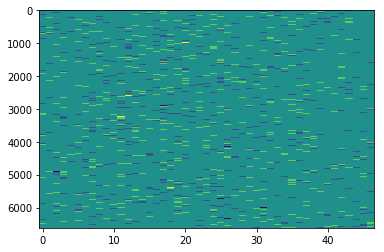

In [149]:
import matplotlib.pyplot as plt
plt.imshow(A, aspect = 'auto')

In [188]:
fake_b = np.random.uniform(low = -400, high = 400, size = (A.shape[0],1))
fake_b.shape

(6618, 1)

In [206]:
# w = np.identity(A.shape[1])*np.random.normal(size = (47,47)) # random weights
w = np.identity(A.shape[1])*0.85 # random weights

In [207]:
x = np.linalg.lstsq(np.dot(A,w), fake_b, rcond=None)[0]

In [209]:
x_2 = np.linalg.lstsq(A, fake_b, rcond=None)[0]